In [ ]:
!pip install scanpy

📂 Data Source: C:\Users\asus\Downloads\spatialgse\Patient_1
💾 Outputs will be saved to: C:\Users\asus\Desktop
⏳ Loading data...
✅ Success! Loaded 4987 spots and 17943 genes.
⚙️  Preprocessing...
📐 Scoring Tissue Regions...
🎨 Generating Spatial Maps...
   ✅ Saved Image: C:\Users\asus\Desktop\Figure1_Spatial_Map.png


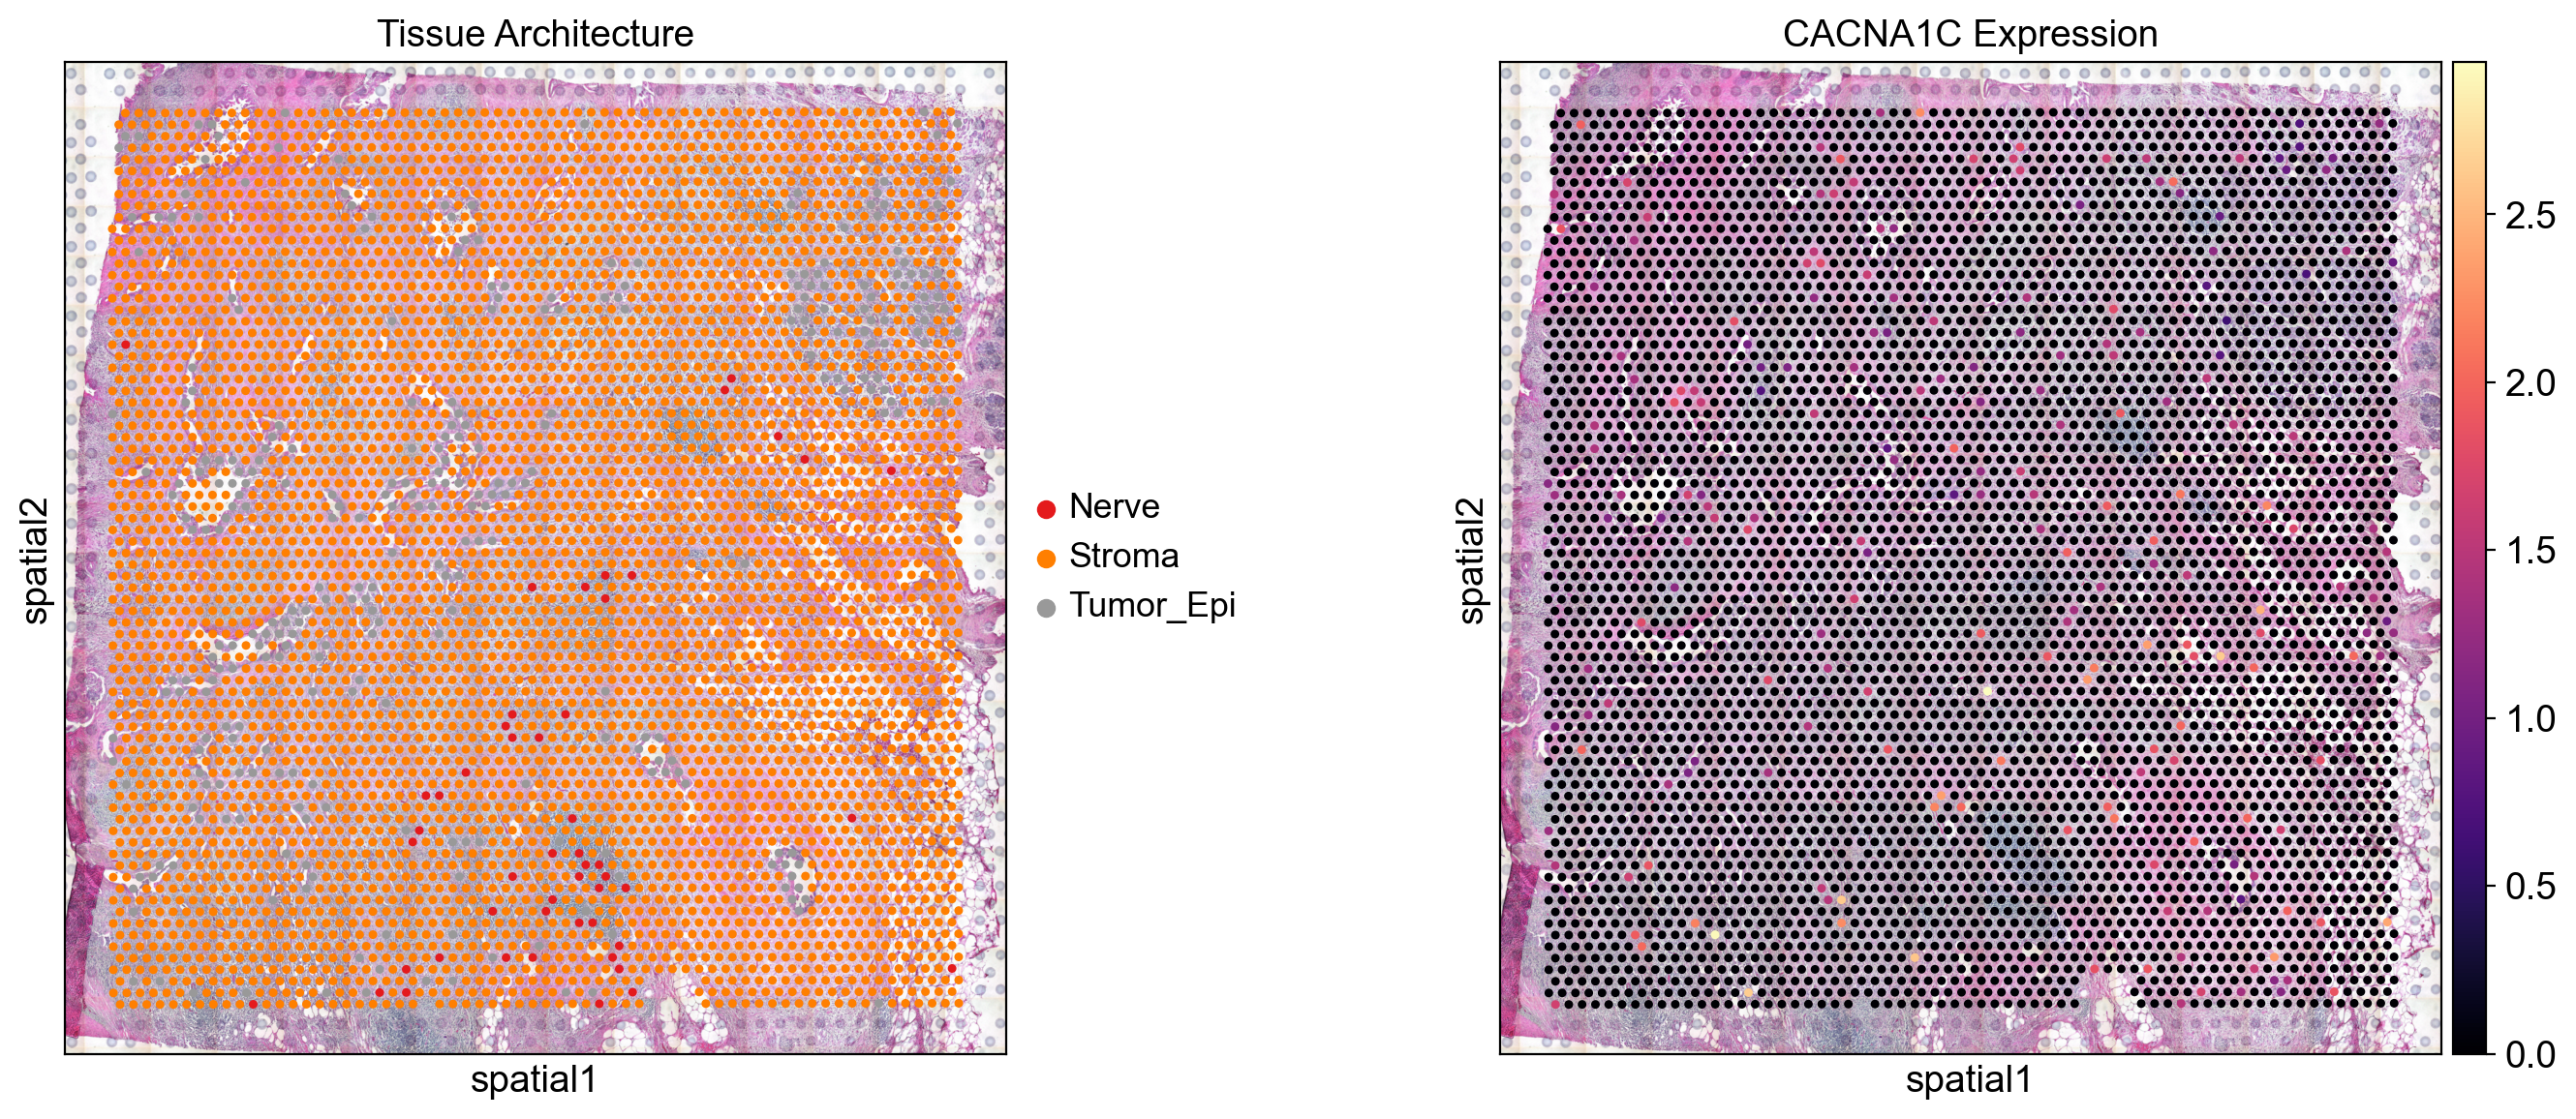

📊 Calculating Statistics...
   ✅ Saved Image: C:\Users\asus\Desktop\Figure2_Boxplot_Stats.png


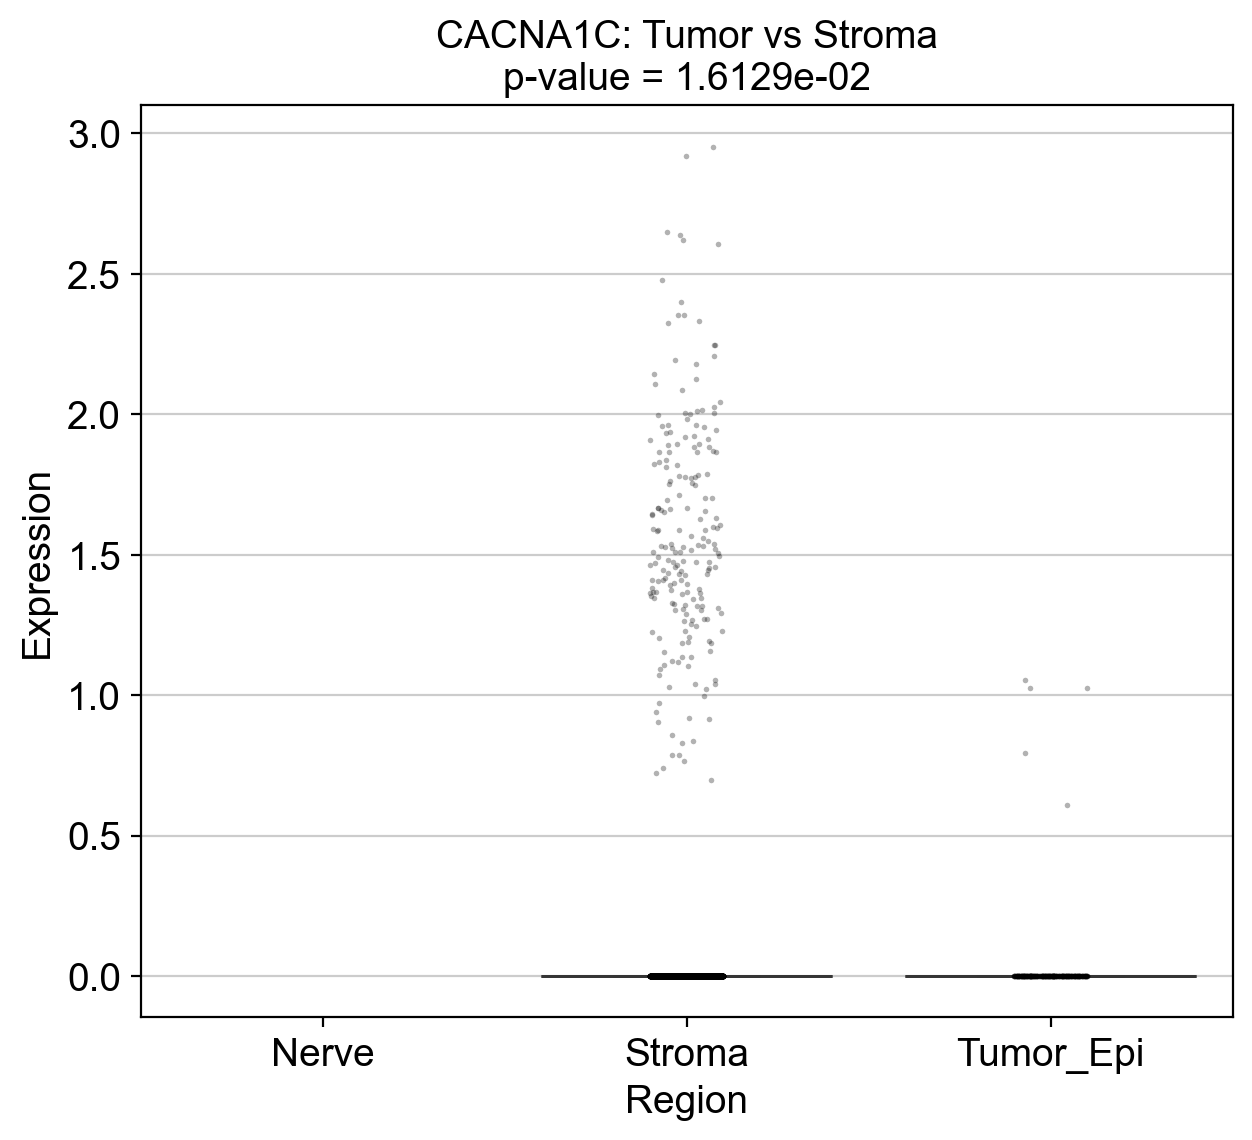


Average Expression:
Region
Nerve        0.000000
Stroma       0.069134
Tumor_Epi    0.014581
Name: Expression, dtype: float32


In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os  # Required for finding Desktop path

# Settings for nicer plots
sc.set_figure_params(dpi=100, color_map='viridis')
warnings.filterwarnings("ignore")

# ==========================================
# 1. SETUP PATHS
# ==========================================
# 🛑 UPDATE THIS PATH to where your Patient_1 folder is
data_path = r"C:\Users\asus\Downloads\spatialgse\Patient_1" 

# 🖥️ AUTOMATICALLY FIND DESKTOP
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
print(f"📂 Data Source: {data_path}")
print(f"💾 Outputs will be saved to: {desktop}")

try:
    # Load the data
    print("⏳ Loading data...")
    adata = sc.read_visium(data_path)
    adata.var_names_make_unique()
    print(f"✅ Success! Loaded {adata.n_obs} spots and {adata.n_vars} genes.")

    # ==========================================
    # 2. PREPROCESSING
    # ==========================================
    print("⚙️  Preprocessing...")
    
    # Calculate QC (Mitochondria)
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    
    # Filter and Normalize
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # ==========================================
    # 3. DEFINE REGIONS
    # ==========================================
    marker_genes = {
        'Tumor_Epi': ['EPCAM', 'KRT19', 'KRT8', 'CDH1'],
        'Stroma':    ['COL1A1', 'FAP', 'DCN', 'ACTA2'],
        'Nerve':     ['SOX10', 'MPZ', 'S100B', 'PLP1']
    }

    print("📐 Scoring Tissue Regions...")
    score_cols = []
    for region, genes in marker_genes.items():
        valid_genes = [g for g in genes if g in adata.var_names]
        if valid_genes:
            sc.tl.score_genes(adata, valid_genes, score_name=f'Score_{region}')
            score_cols.append(f'Score_{region}')

    if score_cols:
        adata.obs['Tissue_Region'] = adata.obs[score_cols].idxmax(axis=1).str.replace('Score_', '')
    
    # ==========================================
    # 4. VISUALIZATION & SAVING (MAPS)
    # ==========================================
    print("🎨 Generating Spatial Maps...")
    target_gene = 'CACNA1C'
    
    if target_gene in adata.var_names:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot 1: Regions
        sc.pl.spatial(adata, color='Tissue_Region', title="Tissue Architecture", 
                      ax=axs[0], show=False, spot_size=None, palette='Set1')
        
        # Plot 2: CACNA1C
        sc.pl.spatial(adata, color=target_gene, title=f"{target_gene} Expression", 
                      ax=axs[1], show=False, spot_size=None, cmap='magma', vmin=0)
        
        plt.tight_layout()
        
        # 💾 SAVE TO DESKTOP
        save_file = os.path.join(desktop, "Figure1_Spatial_Map.png")
        plt.savefig(save_file, dpi=300, bbox_inches='tight')
        print(f"   ✅ Saved Image: {save_file}")
        
        plt.show()

    # ==========================================
    # 5. STATISTICS & SAVING (BOXPLOT)
    # ==========================================
    if target_gene in adata.var_names and 'Tissue_Region' in adata.obs:
        print("📊 Calculating Statistics...")
        
        # Extract data
        if hasattr(adata.X, 'toarray'):
            expr_values = adata[:, target_gene].X.toarray().flatten()
        else:
            expr_values = adata[:, target_gene].X.flatten()
            
        plot_df = pd.DataFrame({
            'Region': adata.obs['Tissue_Region'],
            'Expression': expr_values
        })
        
        subset = plot_df[plot_df['Region'].isin(['Tumor_Epi', 'Stroma'])]
        
        # Plot
        plt.figure(figsize=(7, 6))
        sns.boxplot(data=subset, x='Region', y='Expression', palette='viridis', showfliers=False)
        sns.stripplot(data=subset, x='Region', y='Expression', color='black', alpha=0.3, size=2)
        
        # Stats
        tumor = subset[subset['Region'] == 'Tumor_Epi']['Expression']
        stroma = subset[subset['Region'] == 'Stroma']['Expression']
        if len(tumor) > 0 and len(stroma) > 0:
            stat, pval = stats.mannwhitneyu(tumor, stroma)
            plt.title(f"{target_gene}: Tumor vs Stroma\np-value = {pval:.4e}")
        
        # 💾 SAVE TO DESKTOP
        save_file_box = os.path.join(desktop, "Figure2_Boxplot_Stats.png")
        plt.savefig(save_file_box, dpi=300)
        print(f"   ✅ Saved Image: {save_file_box}")
        
        plt.show()

        print("\nAverage Expression:")
        print(plot_df.groupby('Region')['Expression'].mean())

except OSError as e:
    print(f"\n❌ FILE ERROR: {e}")
    print("👉 Double check your 'spatial' folder filenames (tissue_positions.csv, etc.)")

In [10]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os

# Settings for nicer plots
sc.set_figure_params(dpi=100, color_map='viridis')
warnings.filterwarnings("ignore")

# ==========================================
# 1. SETUP PATHS & PATIENTS
# ==========================================
# 🛑 UPDATE THIS PATH to the PARENT folder containing Patient_1, Patient_2, etc.
base_path = r"C:\Users\asus\Downloads\spatialgse" 

# List of patients to analyze
patients = ["Patient_1", "Patient_2", "Patient_3", "Patient_4", "Patient_5"]

# 🖥️ AUTOMATICALLY FIND DESKTOP
desktop = os.path.join(os.path.expanduser("~"), "Desktop")
print(f"📂 Data Parent Folder: {base_path}")
print(f"💾 Outputs will be saved to: {desktop}")

# ==========================================
# MAIN ANALYSIS LOOP
# ==========================================
for patient_id in patients:
    print(f"\n{'='*40}")
    print(f"🔬 ANALYZING: {patient_id}")
    print(f"{'='*40}")

    # Construct full path for this patient
    data_path = os.path.join(base_path, patient_id)
    
    try:
        # --------------------------------------
        # 2. LOAD DATA
        # --------------------------------------
        if not os.path.exists(data_path):
            print(f"⚠️ Folder not found: {data_path}. Skipping...")
            continue
            
        print("   ⏳ Loading data...")
        adata = sc.read_visium(data_path)
        adata.var_names_make_unique()
        print(f"   ✅ Loaded {adata.n_obs} spots.")

        # --------------------------------------
        # 3. PREPROCESSING
        # --------------------------------------
        adata.var['mt'] = adata.var_names.str.startswith('MT-')
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
        sc.pp.filter_cells(adata, min_genes=100)
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)

        # --------------------------------------
        # 4. DEFINE REGIONS
        # --------------------------------------
        # Added ACTA2 to Stroma definition, but we will analyze it separately too
        marker_genes = {
            'Tumor_Epi': ['EPCAM', 'KRT19', 'KRT8', 'CDH1'],
            'Stroma':    ['COL1A1', 'FAP', 'DCN', 'ACTA2'], 
            'Nerve':     ['SOX10', 'MPZ', 'S100B', 'PLP1']
        }

        score_cols = []
        for region, genes in marker_genes.items():
            valid_genes = [g for g in genes if g in adata.var_names]
            if valid_genes:
                sc.tl.score_genes(adata, valid_genes, score_name=f'Score_{region}')
                score_cols.append(f'Score_{region}')

        if score_cols:
            adata.obs['Tissue_Region'] = adata.obs[score_cols].idxmax(axis=1).str.replace('Score_', '')
        
        # Check if CACNA1C exists
        target_gene = 'CACNA1C'
        if target_gene not in adata.var_names:
            print(f"   ❌ {target_gene} not found in {patient_id}. Skipping plots.")
            continue

        # --------------------------------------
        # 5. VISUALIZATION (MAPS & BOXPLOTS)
        # --------------------------------------
        # --- Figure 1: Spatial Map ---
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        sc.pl.spatial(adata, color='Tissue_Region', title=f"{patient_id}: Tissue Architecture", 
                      ax=axs[0], show=False, spot_size=None, palette='Set1')
        sc.pl.spatial(adata, color=target_gene, title=f"{target_gene} Expression", 
                      ax=axs[1], show=False, spot_size=None, cmap='magma', vmin=0)
        plt.tight_layout()
        plt.savefig(os.path.join(desktop, f"{patient_id}_Fig1_Map.png"), dpi=150)
        plt.close() # Close to save memory

        # --- Figure 2: Boxplot Stats ---
        # Extract expression safely
        if hasattr(adata.X, 'toarray'):
            expr_values = adata[:, target_gene].X.toarray().flatten()
        else:
            expr_values = adata[:, target_gene].X.flatten()
            
        plot_df = pd.DataFrame({'Region': adata.obs['Tissue_Region'], 'Expression': expr_values})
        subset = plot_df[plot_df['Region'].isin(['Tumor_Epi', 'Stroma'])]
        
        plt.figure(figsize=(6, 5))
        sns.boxplot(data=subset, x='Region', y='Expression', palette='viridis', showfliers=False)
        sns.stripplot(data=subset, x='Region', y='Expression', color='k', alpha=0.2, size=2)
        
        # Mann-Whitney
        tumor = subset[subset['Region'] == 'Tumor_Epi']['Expression']
        stroma = subset[subset['Region'] == 'Stroma']['Expression']
        if len(tumor) > 0 and len(stroma) > 0:
            stat, pval = stats.mannwhitneyu(tumor, stroma)
            plt.title(f"{patient_id}: Tumor vs Stroma\np={pval:.4e}")
        
        plt.savefig(os.path.join(desktop, f"{patient_id}_Fig2_Boxplot.png"), dpi=150)
        plt.close()

        # --------------------------------------
        # 6. NEW: VASCULAR HYPOTHESIS TESTING
        # --------------------------------------
        print(f"   🔍 Testing Vascular Hypothesis for {patient_id}...")
        
        # Markers to correlate with CACNA1C
        hypothesis_markers = {
            'Smooth Muscle (ACTA2)': 'ACTA2',
            'Endothelial (PECAM1)': 'PECAM1',
            'Fibroblast (COL1A1)': 'COL1A1',
            'Tumor (EPCAM)': 'EPCAM'
        }
        
        correlations = {}
        
        for label, gene in hypothesis_markers.items():
            if gene in adata.var_names:
                # Get gene expression
                if hasattr(adata.X, 'toarray'):
                    gene_expr = adata[:, gene].X.toarray().flatten()
                else:
                    gene_expr = adata[:, gene].X.flatten()
                
                # Calculate Spearman R
                r, p = stats.spearmanr(expr_values, gene_expr)
                correlations[label] = r
            else:
                correlations[label] = 0 # Gene not found
        
        # --- Figure 3: Correlation Bar Plot ---
        corr_df = pd.Series(correlations)
        
        plt.figure(figsize=(8, 5))
        colors = ['firebrick' if 'Tumor' in x else 'forestgreen' if 'Smooth' in x else 'teal' for x in corr_df.index]
        corr_df.plot(kind='bar', color=colors, alpha=0.8)
        plt.axhline(0, color='k', linewidth=1)
        plt.title(f"{patient_id}: What correlates with CACNA1C?")
        plt.ylabel("Spearman Correlation (R)")
        plt.xticks(rotation=45, ha='right')
        plt.ylim(-0.2, 0.6) # Set consistent scale
        plt.tight_layout()
        
        plt.savefig(os.path.join(desktop, f"{patient_id}_Fig3_Vascular_Corr.png"), dpi=150)
        plt.close()
        
        print(f"   ✅ {patient_id} Done. Top correlate: {corr_df.idxmax()} (R={corr_df.max():.2f})")

    except OSError as e:
        print(f"   ❌ FILE ERROR for {patient_id}: {e}")
    except Exception as e:
        import traceback
        print(f"   ❌ ERROR: {e}")
        traceback.print_exc()

print("\n✅ BATCH ANALYSIS COMPLETE.")

📂 Data Parent Folder: C:\Users\asus\Downloads\spatialgse
💾 Outputs will be saved to: C:\Users\asus\Desktop

🔬 ANALYZING: Patient_1
   ⏳ Loading data...
   ✅ Loaded 4987 spots.
   🔍 Testing Vascular Hypothesis for Patient_1...
   ✅ Patient_1 Done. Top correlate: Endothelial (PECAM1) (R=0.04)

🔬 ANALYZING: Patient_2
   ⏳ Loading data...
   ✅ Loaded 4380 spots.
   🔍 Testing Vascular Hypothesis for Patient_2...
   ✅ Patient_2 Done. Top correlate: Endothelial (PECAM1) (R=0.03)

🔬 ANALYZING: Patient_3
   ⏳ Loading data...
   ✅ Loaded 4134 spots.
   🔍 Testing Vascular Hypothesis for Patient_3...
   ✅ Patient_3 Done. Top correlate: Endothelial (PECAM1) (R=0.04)

🔬 ANALYZING: Patient_4
   ⏳ Loading data...
   ✅ Loaded 4983 spots.
   🔍 Testing Vascular Hypothesis for Patient_4...
   ✅ Patient_4 Done. Top correlate: Endothelial (PECAM1) (R=0.05)

🔬 ANALYZING: Patient_5
   ⏳ Loading data...
   ✅ Loaded 4952 spots.
   🔍 Testing Vascular Hypothesis for Patient_5...
   ✅ Patient_5 Done. Top correlate